In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset
data = [
    ([0.1, 0.2, 0.3], 0), ([0.2, 0.3, 0.1], 0), ([0.4, 0.5, 0.6], 0), ([0.5, 0.4, 0.5], 0),
    ([0.6, 0.7, 0.8], 1), ([0.7, 0.8, 0.6], 1), ([0.9, 0.8, 0.7], 1), ([0.8, 0.9, 0.9], 1)
]

In [3]:
# Define the VQC
def create_vqc(features, params):
    qc = QuantumCircuit(3, 1)
    # Advanced encoding
    for i, x in enumerate(features):
        qc.ry(x * np.pi, i)
        qc.rz(x * np.pi, i)
    # Layer 1
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.ry(params[2], 2)
    qc.cx(0, 1)
    qc.cx(1, 2)
    # Layer 2
    qc.ry(params[3], 0)
    qc.ry(params[4], 1)
    qc.ry(params[5], 2)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure(0, 0)
    return qc

In [4]:
# Simulate with statevector
def run_circuit(features, params):
    qc = create_vqc(features, params)
    simulator = StatevectorSimulator()
    result = simulator.run(qc).result()
    counts = result.get_counts()
    prob_0 = counts.get('0', 0) / sum(counts.values())
    return prob_0

In [17]:
# Cost function
def cost_function(params):
    total_cost = 0
    for features, label in data:
        prob_0 = run_circuit(features, params)
        target_prob = 1.0 if label == 0 else 0.0
        total_cost += (prob_0 - target_prob) ** 2
    return total_cost / len(data)

In [18]:
# Parameter shift rule gradient
def compute_gradient(params):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        # Shift parameter i by +π/2 and -π/2
        params_plus = params.copy()
        params_minus = params.copy()
        params_plus[i] += np.pi / 2
        params_minus[i] -= np.pi / 2
        grad[i] = (cost_function(params_plus) - cost_function(params_minus)) / 2
    return grad

In [19]:
# Gradient descent optimization
def optimize_params(initial_params, learning_rate=0.1, max_iter=100):
    params = initial_params.copy()
    costs = []
    for _ in range(max_iter):
        grad = compute_gradient(params)
        params -= learning_rate * grad
        cost = cost_function(params)
        costs.append(cost)
        if np.linalg.norm(grad) < 1e-3:  # Convergence check
            break
    return params, costs

In [20]:
# Run optimization
initial_params = np.random.uniform(0, np.pi, 6)
print(f"Initial parameters: {initial_params}")
optimal_params, costs = optimize_params(initial_params)
print(f"Optimized parameters: {optimal_params}")
print(f"Final cost: {costs[-1]:.6f}")

Initial parameters: [3.03546151 0.31778315 1.9853608  0.65435127 2.62506201 1.04941099]


ValueError: An invalid Sampler pub-like was given (<class 'qiskit._accelerate.circuit.CircuitInstruction'>). If you want to run a single circuit, you need to wrap it with `[]` like `sampler.run([circuit])` instead of `sampler.run(circuit)`.

In [21]:
# Test results
for features, label in data:
    prob_0 = run_circuit(features, optimal_params)
    prediction = 1 if prob_0 < 0.5 else 0
    print(f"Features: {features}, True Label: {label}, P(|0⟩): {prob_0:.4f}, Predicted: {prediction}")

ValueError: An invalid Sampler pub-like was given (<class 'qiskit._accelerate.circuit.CircuitInstruction'>). If you want to run a single circuit, you need to wrap it with `[]` like `sampler.run([circuit])` instead of `sampler.run(circuit)`.

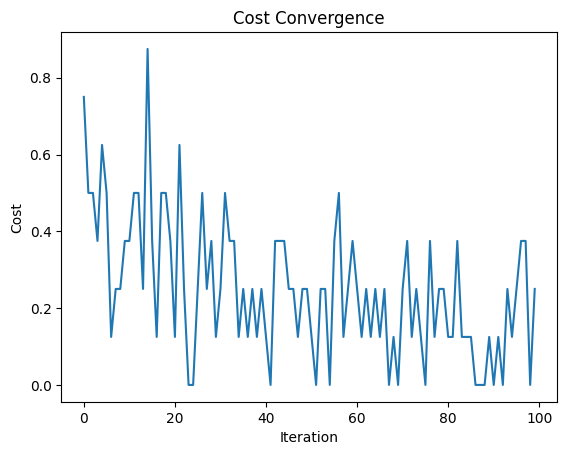

In [13]:
# Plot convergence
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Convergence')
plt.show()

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(mode=backend)
def run_circuit(features, params):
    qc = create_vqc(features, params)
    job = sampler.run(qc, shots=1024)
    result = job.result()
    counts = result.quasi_dists[0].binary_probabilities()
    return counts.get('0', 0)

In [15]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
n_qubits = 50
 
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=n_qubits
)
 
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
observable = SparsePauliOp("Z" * 50)
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
estimator = Estimator(mode=backend)
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()
 
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: 0.19447513812154696
 > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}
